ReadMe
-------

Please note that the poi_id.py contains only functions and is imported as python modul.
I walked trough the project as follows:

1. Preparing final dataset (new feature, outlier removal)
2. Sort features according scores using KBest
3. Run classifier with different features range (2-15)
4. Select features
5. Run GridsearchCV with selected features for algorithm tuning
6. Repeat step 3 for check
7. Validate algorithm
8. Save final data
9. Check with tester_project.py

In [1]:
from __future__ import division, print_function
import pprint
import pandas as pd
import sys
import seaborn as sns
sns.set()

sys.path.append("../tools/")
pd.set_option('display.expand_frame_repr', False)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [3]:
# Import Functions
import poi_id_v2 as poi
import tester_project as tester
from feature_format import featureFormat, targetFeatureSplit

Identify Fraud from Enron Email
======

Project Overview
-----------------

Enron was a big energy company founded in 1985 out of three north american energy companies . After deregulation of the energy market, Enron became the largest seller of natural gas in North America by 1992.
A very complex business model itself, complex financial statements and unethical practices resulted in misrepresentation of  earnings and modifcation of balance sheets in large scale. This kind of fraud was driven and pushed by enron managment. The fraud key-player are named hereafter persons of interest 'POI'.
In november 2001 the enron story ends with the largest bankruptcy in U.S. historys since 1970.

https://en.wikipedia.org/wiki/Enron_scandal

The provided project data is a hand curated dataset of more than hundred enron employes, mainly enron high management.
The source of the data is a large e-mail collection, which was published from Fedral Energy Regulatory Commission during the process

Project Question 1
------

*Summarize for us the goal of this project and how machine learning is
useful in trying to accomplish it. As part of your answer, give some
background on the dataset and how it can be used to answer the
project question. Were there any outliers in the data when you got it,
and how did you handle those? [relevant rubric items: “data
exploration”, “outlier investigation”]*

### Q1

Goal of the project is to build a prediction model that can predict POIs / Non-POIs with high accuracy based on the provided data.

The type of dataset is a dictionary where the keys are enron persons with their names:

 * 146 Names  
 * 18 Names marked as POI

Behind every name a feature dictionary with metadata can be found:  
 * 21 Features


In [4]:
# Load Data
data_dict = poi.load_dataset()

In [5]:
print ("Datapoints:",len(data_dict))
print ("Features:",len(data_dict['BELDEN TIMOTHY N']))

# Check features
feature_list        = poi.get_feature(data_dict, [])
df = pd.DataFrame.from_dict(data_dict, orient='index', columns =feature_list )
mask = df['poi']==True
print ("Person of Interest (POI):",len(df[mask]['poi']))
print ('')
print ('List of POIs:')
print ('')
print (df[mask]['poi'])

Datapoints: 146
Features: 21
Person of Interest (POI): 18

List of POIs:

BELDEN TIMOTHY N        True
BOWEN JR RAYMOND M      True
CALGER CHRISTOPHER F    True
CAUSEY RICHARD A        True
COLWELL WESLEY          True
DELAINEY DAVID W        True
FASTOW ANDREW S         True
GLISAN JR BEN F         True
HANNON KEVIN P          True
HIRKO JOSEPH            True
KOENIG MARK E           True
KOPPER MICHAEL J        True
LAY KENNETH L           True
RICE KENNETH D          True
RIEKER PAULA H          True
SHELBY REX              True
SKILLING JEFFREY K      True
YEAGER F SCOTT          True
Name: poi, dtype: bool


### Q1

During the first quick check of the dataset, it was observed that a lot of features showing 'NaN' entries, which means no information available. To get an overview about the 'NaN' proportion per feature, the overview is shown below in table format.
As we can see, the completeness of data is varying a lot for the different features. This will probably play a more important role when i have to select the features for the model training. For the moment i will use the first 5 most complete features for a first visualization to see how the datapoints are spread.

The scatter plots show clearly one very dominant outlier, which was found to be a non-real person. In total i have removed:

 * 'TOTAL'  (non-real person)
 * 'THE TRAVEL AGENCY IN THE PARK'  (non-real person)
 * 'LOCKHART EUGENE E'  (all features NaN) 

In [6]:
print (poi.nan_check(data_dict))

                           NaN Count  NaN Proportion
poi                                0        0.000000
total_stock_value                 20        0.136986
total_payments                    21        0.143836
email_address                     35        0.239726
restricted_stock                  36        0.246575
exercised_stock_options           44        0.301370
salary                            51        0.349315
expenses                          51        0.349315
other                             53        0.363014
to_messages                       60        0.410959
from_this_person_to_poi           60        0.410959
shared_receipt_with_poi           60        0.410959
from_messages                     60        0.410959
from_poi_to_this_person           60        0.410959
bonus                             64        0.438356
long_term_incentive               80        0.547945
deferred_income                   97        0.664384
deferral_payments                107        0.

C:\Users\PetzM\anaconda3\envs\Machine_Learning\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\PetzM\anaconda3\envs\Machine_Learning\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


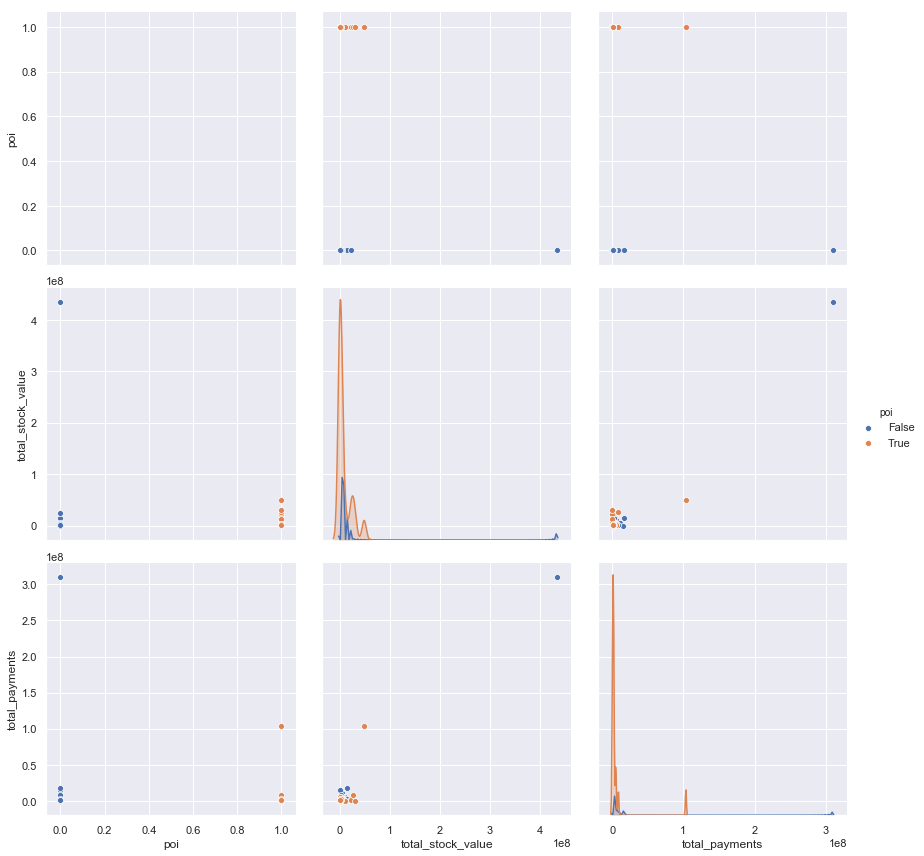

In [7]:
feature_list = ['poi', 'total_stock_value', 'total_payments']
df=poi.df_features(data_dict,feature_list)
sns.pairplot(df, hue='poi',height=4)

In [8]:
# Identify outlier
poi.check_outlier(data_dict, 'total_payments')
print ('')

# Check data for additional problematic datapoints
nan_email_list, nan_all_list, poi_data_dict = poi.check_dataset(data_dict)
print (nan_all_list)

# Remove identified problematic datapoints
outlier = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
my_dataset = poi.remove_outlier(data_dict, outlier)

   total_payments              Name    Poi
0       309886585             TOTAL  False
1       103559793     LAY KENNETH L   True
2        17252530    FREVERT MARK A  False
3        15456290  BHATNAGAR SANJAY  False
4        10425757   LAVORATO JOHN J  False

['LOCKHART EUGENE E']


Project Question 2
------

*What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.
[relevant rubric items: “create new features”, “intelligently select
features”, “properly scale features”]*

### Q2

Before going into feature selection process i have created two additional features based on already available message informations:

 * 'fraction_from_poi' = 'from_poi_to_this_person' / 'to_messages'
 * 'fraction_to_poi' = 'from_this_person_to_poi' / 'from_messages'
 
The rationale behind, is that these new features will probably provide more informations than total numbers of received or send messages. A high fraction of information traffic with a POI might identify the person itself as POI.

The new created features were not checked explicitly, since i have used as next step SelectKBest for ranking all the features according to their scores.

In [9]:
# Create new features
my_dataset = poi.create_new_message_feature(my_dataset)

# Exclude non-relevant features and get final feature List
excluded_features   = ['email_address']
feature_list        = poi.get_feature(my_dataset, excluded_features)

# Split data in labels and features
data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [10]:
k=len(features[0])

# Get sorted features according the KBest scores
kBest_features, sorted_scores, kBest_features_list = poi.get_KBest(features, labels, k, feature_list)

sorted_features_list = ['poi'] + kBest_features_list

print (pd.DataFrame(sorted_scores,columns=['Feature','KBest Score']))

                      Feature  KBest Score
0     exercised_stock_options    24.815080
1           total_stock_value    24.182899
2                       bonus    20.792252
3                      salary    18.289684
4             fraction_to_poi    16.409713
5             deferred_income    11.458477
6         long_term_incentive     9.922186
7            restricted_stock     9.212811
8              total_payments     8.772778
9     shared_receipt_with_poi     8.589421
10              loan_advances     7.184056
11                   expenses     6.094173
12    from_poi_to_this_person     5.243450
13                      other     4.187478
14          fraction_from_poi     3.128092
15    from_this_person_to_poi     2.382612
16              director_fees     2.126328
17                to_messages     1.646341
18          deferral_payments     0.224611
19              from_messages     0.169701
20  restricted_stock_deferred     0.065500


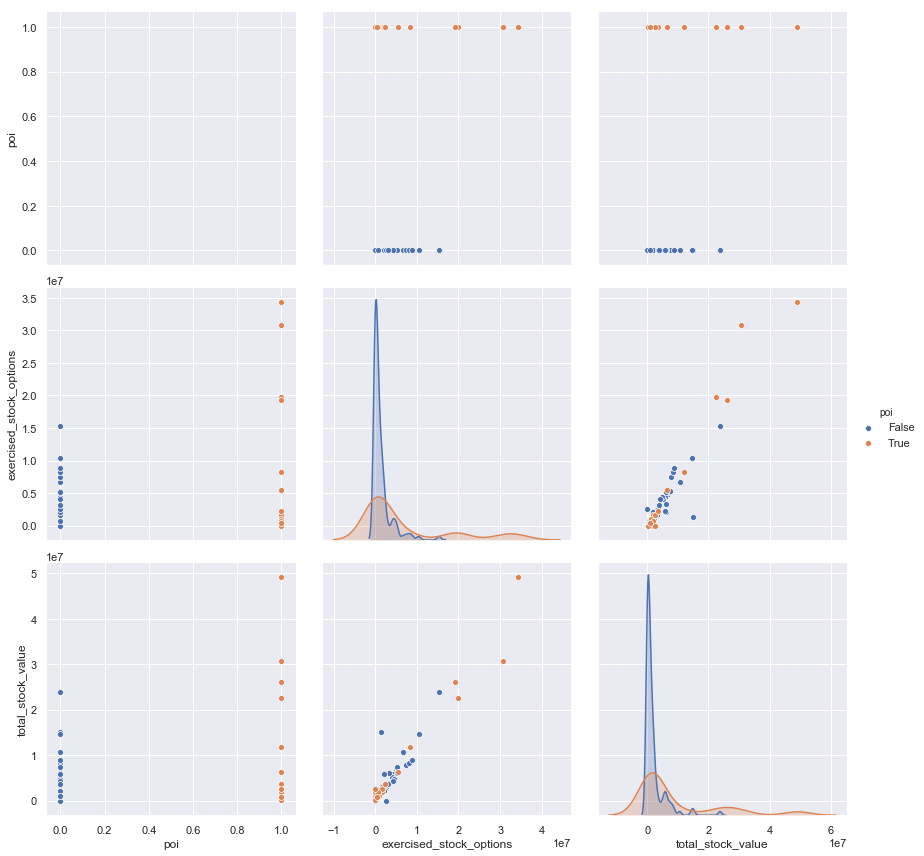

In [11]:
feature_list = ['poi', 'exercised_stock_options', 'total_stock_value']
df=poi.df_features(my_dataset,feature_list)
sns.pairplot(df, hue='poi',height=4)

I have tested the performance of different classifiers in a feature range 2-16 based on the KBest ranking. Finally i decided to select the first 6 KBest features for the model training for which i have received the best f1 scores.
  
Before passing them into my classifier, the selected features were scaled with a min-max scaler. This is necessary because the different features having also different units (e.g. dollar vs. message number) and therefore also large discrepancies in the range of values. Some classifiers don't consider these effects, but the SVM i selected does.

Project Question 3
------

*What algorithm did you end up using? What other one(s) did you try?
How did model performance differ between algorithms? [relevant
rubric item: “pick an algorithm”*

### Q3

I have tried three different alogrithm which are:

 * 'DecisionTree'  
 * 'GaussianNB'  
 * 'SVC'
 
With all of them i got **precision and recall >.3**. The best perfomance in terms of accuracy and precision was achieved with naive bays (GaussianNB). The best recall and f1 score was obtained with support vector classification (SVC) after running a **GridsearchCV** for the best f1 score. The descion tree classifier was not checked further.
Due to best f1 score i selected the **SVC classifier** for final project evaluation.
Compared to non-POI there is a low proportion of POI in the dataset (uneven class distribution). Therefore the f1 score is a better identifier for a good working classifier compared to accuracy.  
No further detailed investigation was done for naive bays classifier and descion tree classifier.

In [12]:
# Dictionary with different classifiers
clf_dict = {'DecisionTree': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=3,
                            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
                            splitter='best'),
            'GaussianNB':   GaussianNB(),
            'SVC':          SVC(C=300, cache_size=200, class_weight='balanced', coef0=0.0,
                            decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
                            max_iter=-1, probability=False, random_state=None, shrinking=True,
                            tol=0.001, verbose=False)}

k=[4,5,6,7,8,9,10,11,12,13,14,15,16]

clf_key = 'SVC'

# Main function
## Input:
## [k] = list of different features quantity
## clf_dict = dictionary with different classifiers
## sorted_features_list = ranked features according KBest scores (complete)
## my_dataset = modified data_dict
f1, k_best_features_number, selected_features_list, pipe, df_k_result, df_k_best_result = poi.clf_func(k, clf_dict, sorted_features_list, my_dataset, clf_key)

print ('')
print ('Result Summary for K-Features')
print ('')
print (df_k_result)
print ('')
print ('Best Results for ', k_best_features_number, ' features')
print ('')
print ('Selected Fetaures: ',len(selected_features_list[1:]), selected_features_list[1:])
print ('')
print (df_k_best_result)
print ('')


Result Summary for K-Features

    accuracy  precision   recall      f1  total_predictions    tp    fp    fn     tn
4     0.8090     0.3020   0.2766  0.2887              13000   504  1165  1318  10013
5     0.7890     0.3345   0.5903  0.4271              14000  1101  2190   764   9945
6     0.7895     0.3369   0.6547  0.4449              14000  1181  2324   623   9872
7     0.7767     0.3209   0.6563  0.4310              14000  1184  2506   620   9690
8     0.7664     0.3087   0.6563  0.4199              14000  1184  2651   620   9545
9     0.7660     0.3013   0.6489  0.4115              15000  1227  2846   664  10263
10    0.7533     0.2916   0.6695  0.4063              15000  1266  3075   625  10034
11    0.7475     0.2769   0.6224  0.3833              15000  1177  3074   714  10035
12    0.7317     0.2505   0.5664  0.3473              15000  1071  3205   820   9904
13    0.7226     0.2489   0.5949  0.3510              15000  1125  3395   766   9714
14    0.7223     0.2482   0.5928 

Text(0,0.5,'F1-Score')

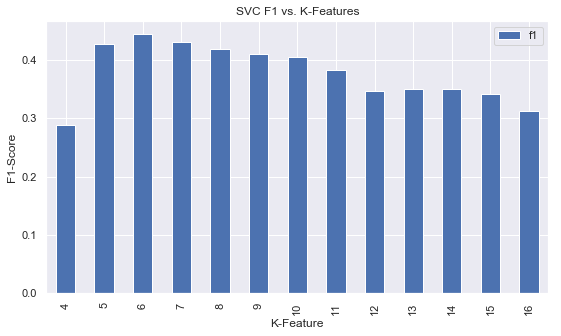

In [17]:
df_k_result.plot(kind='bar', y='f1', figsize=(9,5))
plt.title('SVC F1 vs. K-Features')
plt.xlabel('K-Feature')
plt.ylabel('F1-Score')

Project Question 4
------

*What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree
classifier). [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]*

### Q4

The SVC classifier was tuned using GridsearchCV for parameter C, gamma and class_weight on a training set of 80% of the available data. The remaining 20% were kept as test data.
The GridsearchCV target score was set to 'f1', since it is the weighted average of precision and recall and takes both false positives and false negatives into account.
If you tune your algorithm you have to take care that you repeat this process several times, especially if you have small datasets with an unbalanced class distribution. Otherwhise you might get pretty good results on your training set, but bad scores when you test your data. This effect is called over/underfitting.  
In my case, i have used **StratifiedShuffleSplit** with 50 folds when running GridsearchCV.  
The input classifier was setup with a randomly select C = 1000 and gamma ='auto'.  
An optimal choice of the parameter set will decide about your final scores. It's a case by case descision on which score you want to concentrate, but of course if you can optimize the classifier to get both prescision and recall with good scores the job is done very well.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_param(key):

    param_grid_dict = { 'SVC':         {'clf__C':               [1, 50, 100, 200, 300, 500, 1e3, 5e3, 1e4, 5e4, 1e5],
                                        'clf__gamma':           ['scale','auto', 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                                        'clf__class_weight':    ['balanced', None]},
                        'DecisionTree': {'clf__min_samples_split':  [2,3,4,5,6,7],
                                        'clf__criterion':           ['gini', 'entropy'],
                                        'clf__max_features':        [None, 1,2,3,4],
                                        'clf__class_weight':        ['balanced', None]},
                        'GaussianNB':   {},
                                        }
 
    return param_grid_dict[key]

######

def clf_opt(key,clf,features,labels):

    param_grid = get_param(key)
    
    scaler = MinMaxScaler()

    pipe = Pipeline([('scaler', scaler), ('clf', clf)])

    cv = StratifiedShuffleSplit(n_splits=100,random_state=42)

    search = GridSearchCV(pipe, param_grid,  cv = cv, scoring = 'f1')

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.10, random_state=42, stratify=labels)
    search.fit(features_train, labels_train)

    print ('Proportion of poi in label_test : ',round(sum(labels_test)/len(labels_test),3))
    print ('Proportion of poi in label_train : ',round(sum(labels_train)/len(labels_train),3))
    print ('')
    print ('Grid best parameter: ', search.best_params_)
    print ('Grid best score: ', search.best_score_)
    print ('Grid best estimator: ',search.best_estimator_.named_steps['clf'])
    print ('')
    clf = search.best_estimator_.named_steps['clf']
    scaler = search.best_estimator_.named_steps['scaler']

    features_test = scaler.transform(features_test)
    labels_pred = clf.predict(features_test)
    print ('Validate with test set.')
    print ('')
    print ('Validate accuracy: ',round(accuracy_score(labels_test, labels_pred),3))
    print ('Validate precision: ',round(precision_score(labels_test, labels_pred),3))
    print ('Validate recall: ',round(recall_score(labels_test, labels_pred),3))
    print ('Validate f1: ',round(f1_score(labels_test, labels_pred),3))

data = featureFormat(my_dataset, selected_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

clf = SVC(C=1000, gamma='auto')
key = 'SVC'

clf_opt(key,clf,features,labels)

C:\Users\PetzM\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Proportion of poi in label_test :  0.143
Proportion of poi in label_train :  0.127

Grid best parameter:  {'clf__gamma': 0.01, 'clf__C': 300, 'clf__class_weight': 'balanced'}
Grid best score:  0.5079696969696971
Grid best estimator:  SVC(C=300, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Validate with test set.

Validate accuracy:  0.714
Validate precision:  0.25
Validate recall:  0.5
Validate f1:  0.333


Project Question 5
------

*What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis? [relevant rubric items: “discuss validation”, “validation strategy”]*

### Q5

As our goal is to train a classifier to provide reliable predictions on a **new data set**, we have to break off the available data into training and test set. The classifier is trained on the training data and the test data is considered as ***new data set***. We assume/hope the performance will be similar as when we use real new data.
If you train your model on all available data and do the split afterwards the test data has already infiltrated the model since the test data was already used for training.  
This might lead to a very well performing model, but once it's used to predict real new data, the results will be not accurate.  
To be sure that your model works well, we validate the predicted values with a reserved test set.

Also, if we have a very unbalanced class distribution, the risk is high to get with only a few iterations (small number of samples) pretty good results on our training set, but bad scores when on the test data.

The algorithm parameter tuning was performed with GridsearchCV on a 90% training set with 100 random splits on this training data. The results have been validated once on a 10% test set, which was not used for training.

As next step, the tuned classifier was tested on **1000** different train/test samples using ***train_test_split*** method with a **90/10** split. Different samples were generated by changing the random_state parameter 1000 times.


As comparison the **tester_project.py** is using ***StratifiedShuffleSplit*** which is a different method to generate 1000 folds.

Both validation functions are counting the total number of predictions, as well as:
 * True Positives (tp)
 * False Positives (fp)
 * False Negatives (fn)
 * True Negatives (tn)
 
Based on this values the following metric scores are caluclated:
 * Accuracy
 * Prescision
 * Recall
 * F1
 * F2

Project Question 6
------

*Give at least 2 evaluation metrics and your average performance for each of them. Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.[relevant rubric item: “usage of evaluation metrics”]*

### Q6

The results of my classifier meets the target score for prescision and recall >0.3.  

 * Prescision = ratio of true positives / total positives
 * Recall = ratio of true positives / (true positives + false negatives)  
 
I would say that my classifier works on the conservative side. I have a good recall score, which means a relative small number of false negative which is good. My prescision score has still some room for improvement, which can be seen on the relative high count of false positives.
My classifier predicts real POIs but will trigger a lot of false alarms. But this is at lease better to have a high number of false negatives.

Finally it's a case by case descision, if we want to accept the false positives or not. At the end it's a businiss case.

In [15]:
acc, pre, rec, f1, total, tp, fp, fn, tn = df_k_result.loc[k_best_features_number].to_numpy()

print ('')
print ('True Positives (tp) :', tp)
print ('False Positives (fp) :', fp)
print ('False Negatives (fn) :', fn)
print ('True Negatives (tn) :', tn)
print ('')
print ('Accuracy: ', (tp+tn)/(tp+fp+tn+fn))
print ('Prescision: ', tp/(tp+fp))
print ('Recall: ', tp/(tp+fn))



True Positives (tp) : 1181.0
False Positives (fp) : 2324.0
False Negatives (fn) : 623.0
True Negatives (tn) : 9872.0

Accuracy:  0.7895
Prescision:  0.3369472182596291
Recall:  0.6546563192904656


Evaluation
------



The **tester_project.py** which is using ***StratifiedShuffleSplit*** gives similar results as the ***train_test_split*** method.

In [16]:
# Save project data as pkl files

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

dump_classifier_and_data(pipe, my_dataset, selected_features_list)

# Load pkl files for evaluation
tester.test_classifier(pipe, my_dataset, selected_features_list, folds = 1000)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=300, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.79121	Precision: 0.37011	Recall: 0.65750	F1: 0.47362	F2: 0.56912
	Total predictions: 14000	True positives: 1315	False positives: 2238	False negatives:  685	True negatives: 9762

